In [29]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import uniform
from scipy.stats import randint
import seaborn as sns

# Modeling packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

In [30]:
travellers = pd.read_csv('../data/final_data.csv')

train, test = train_test_split(travellers, train_size=0.7, random_state=123)

X_train = train.drop('Price', axis=1)
y_train = train[['Price']]
X_test = test.drop('Price', axis=1)
y_test = test[['Price']]

In [31]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
    ("scale", StandardScaler(), selector(dtype_include="number")),
    ("one-hot", OneHotEncoder(), selector(dtype_include="object"))
  ])

In [33]:
rf_mod = RandomForestRegressor()

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(model_pipeline, X_train, y_train.values.ravel(), cv=kfold, scoring=loss)


In [34]:
np.abs(np.mean(results))

1733.8917251328708

In [35]:
%%capture

# create random forest estimator with 1,000 trees
rf_mod = RandomForestRegressor(n_estimators=1000)


# Create grid of hyperparameter values
hyper_grid = {
  'rf_mod__max_features': [.05, .15, .25, .333, .4, .5, .6],
  'rf_mod__min_samples_leaf': [1, 3, 5, 10, 15, 20],
  'rf_mod__bootstrap': [True, False],
  'rf_mod__max_samples': [.5, .63, .8]
  }
  
# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss, n_jobs=-1)
results = grid_search.fit(X_train, y_train.values.ravel())

In [36]:
np.abs(results.best_score_)

1710.2928528704783

In [37]:
results.best_params_

{'rf_mod__bootstrap': True,
 'rf_mod__max_features': 0.6,
 'rf_mod__max_samples': 0.8,
 'rf_mod__min_samples_leaf': 1}

In [38]:
%%capture

# Create grid of hyperparameter values
hyper_distributions = {
  'rf_mod__max_features': uniform(.05, .35),
  'rf_mod__min_samples_leaf': randint(1, 9),
  'rf_mod__bootstrap': [True, False],
  'rf_mod__max_samples': uniform(.5, .3)
  }
  
# Tune a knn model using grid search
random_search = RandomizedSearchCV(
  model_pipeline, 
  param_distributions=hyper_distributions, 
  n_iter=20,
  cv=kfold, 
  scoring=loss, 
  n_jobs=-1, 
  random_state=13
  )
random_search_results = random_search.fit(X_train, y_train.values.ravel())

In [39]:
np.abs(random_search_results.best_score_)

1729.184425109716

In [40]:
random_search_results.best_params_

{'rf_mod__bootstrap': True,
 'rf_mod__max_features': 0.37868729205270835,
 'rf_mod__max_samples': 0.6615164397309103,
 'rf_mod__min_samples_leaf': 1}

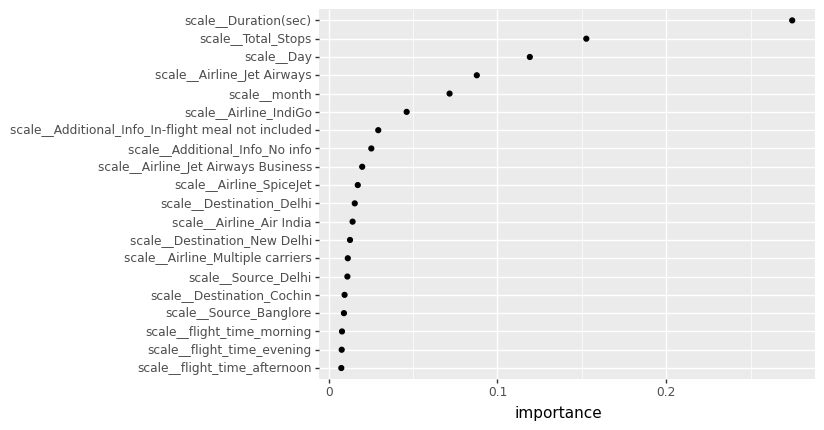

<ggplot: (8736394572246)>

In [45]:
X_encoded = preprocessor.fit_transform(X_train)
final_model = RandomForestRegressor(
  n_estimators=1000,
  max_features=0.21,
  max_samples=0.65,
  min_samples_leaf=1,
  bootstrap=True
)
final_model_fit = final_model.fit(X_encoded, y_train.values.ravel())

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names_out(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))